# South Park TTS Data

The purpose of this [SoS notebook](https://vatlab.github.io/sos-docs/) is to prepare a dataset for learning a text to speech (TTS) system from South Park video data.

The general pipeline is applicable to creating TTS data when subtitles are available, *except* for the speaker identification component used here, which requires South Park transcripts with speaker annotations.
It's possible that the method of speaker identification used here would translate to other datasets that had some type of speaker annotation, but this would likely require some nontrivial modification.

Creating the South Park TTS dataset involved the following steps:

1. Convert DVDs
2. Extract subtitles
3. Align subtitles with audio sufficiently for labeled data needs
4. Do speaker identification
5. Create WAV/transcript data in suitable format (e.g. [LJSpeech](https://keithito.com/LJ-Speech-Dataset/))

## DVD conversion

Originally the goal was to just get the ISOs for the DVDs to allow batch processing.
However, strange obfuscation was used on the DVDs, presumably to prevent copyright infringement.
As a result, each DVD had to be transcoded to MP4 using Handbrake. 
This was the only option of those tried that preserved the subtitle information.
The following manual steps were used:

- Discs up to season 13 where converted to ISO using various programs (NOTE: Handbrake could probably have been used instead and would have resulted in more homogenous outputs; some idiosyncratic processing below could possibly have been avoided by using Handbrake everywhere)
- Handbrake was run over these and then each succeeding disc
    - Seasons 1-12: detelecine + decombe (4:3 format)
    - Season 13-17: no detelecine or decombe
    - Season 18-20: detelecine + decombe
    - Season 15-20: closed captions replaced with image subtitles

This is an example settings file for HandBrake 1.1.0 for detelecine + decombe for CC or VobSub
```
{
    "PresetList": [
        {
            "AlignAVStart": true,
            "AudioCopyMask": [
                "copy:aac"
            ],
            "AudioEncoderFallback": "av_aac",
            "AudioLanguageList": [],
            "AudioList": [
                {
                    "AudioBitrate": 160,
                    "AudioCompressionLevel": -1.0,
                    "AudioDitherMethod": "auto",
                    "AudioEncoder": "av_aac",
                    "AudioMixdown": "dpl2",
                    "AudioNormalizeMixLevel": false,
                    "AudioSamplerate": "auto",
                    "AudioTrackDRCSlider": 0.0,
                    "AudioTrackGainSlider": 0.0,
                    "AudioTrackQuality": 1.0,
                    "AudioTrackQualityEnable": false
                }
            ],
            "AudioSecondaryEncoderMode": true,
            "AudioTrackSelectionBehavior": "first",
            "ChapterMarkers": true,
            "ChildrenArray": [],
            "Default": false,
            "FileFormat": "av_mp4",
            "Folder": false,
            "FolderOpen": false,
            "InlineParameterSets": false,
            "Mp4HttpOptimize": false,
            "Mp4iPodCompatible": false,
            "PictureAutoCrop": true,
            "PictureBottomCrop": 0,
            "PictureCombDetectCustom": "",
            "PictureCombDetectPreset": "default",
            "PictureDARWidth": 0,
            "PictureDeblock": 0,
            "PictureDeblockCustom": "qp=0:mode=2",
            "PictureDeinterlaceCustom": "",
            "PictureDeinterlaceFilter": "decomb",
            "PictureDeinterlacePreset": "default",
            "PictureDenoiseCustom": "",
            "PictureDenoiseFilter": "off",
            "PictureDenoisePreset": "",
            "PictureDenoiseTune": "none",
            "PictureDetelecine": "default",
            "PictureDetelecineCustom": "",
            "PictureForceHeight": 0,
            "PictureForceWidth": 0,
            "PictureHeight": 720,
            "PictureItuPAR": false,
            "PictureKeepRatio": true,
            "PictureLeftCrop": 0,
            "PictureLooseCrop": false,
            "PictureModulus": 2,
            "PicturePAR": "auto",
            "PicturePARHeight": 27,
            "PicturePARWidth": 32,
            "PictureRightCrop": 0,
            "PictureRotate": "disable=1",
            "PictureSharpenCustom": "",
            "PictureSharpenFilter": "off",
            "PictureSharpenPreset": "",
            "PictureSharpenTune": "",
            "PictureTopCrop": 0,
            "PictureWidth": 1280,
            "PresetDescription": "southpark-reconstructed-vobsub-detelecine-decomb",
            "PresetName": "southpark-reconstructed-vobsub-dete-deco",
            "SubtitleAddCC": false,
            "SubtitleAddForeignAudioSearch": true,
            "SubtitleAddForeignAudioSubtitle": false,
            "SubtitleBurnBDSub": true,
            "SubtitleBurnBehavior": "foreign",
            "SubtitleBurnDVDSub": true,
            "SubtitleLanguageList": [],
            "SubtitleTrackSelectionBehavior": "none",
            "Type": 1,
            "UsesPictureFilters": true,
            "UsesPictureSettings": 1,
            "VideoAvgBitrate": 3000,
            "VideoColorMatrixCode": 0,
            "VideoEncoder": "x264",
            "VideoFramerate": "30",
            "VideoFramerateMode": "pfr",
            "VideoGrayScale": false,
            "VideoLevel": "3.1",
            "VideoOptionExtra": "",
            "VideoPreset": "fast",
            "VideoProfile": "main",
            "VideoQSVAsyncDepth": 4,
            "VideoQSVDecode": false,
            "VideoQualitySlider": 21.0,
            "VideoQualityType": 2,
            "VideoScaler": "swscale",
            "VideoTune": "",
            "VideoTurboTwoPass": true,
            "VideoTwoPass": true,
            "x264Option": "",
            "x264UseAdvancedOptions": false
        }
    ],
    "VersionMajor": 32,
    "VersionMicro": 0,
    "VersionMinor": 0
}
```

## Extract subtitles and wav

For CC subtitles (seasons 1-14), `srt` files are easily extracted with:

`ffmpeg -txt_format text -i NAME.mp4 NAME.srt`

For VobSub, we first need to get the track index for subtitles using [MP4Box](https://gpac.wp.imt.fr/mp4box/), extract `idx`/`sub` files using MP4Box, and then convert these to `srt` using [VobSub2SRT](https://github.com/ruediger/VobSub2SRT). The commands are:

`MP4Box -info input.mp4` to get the `sub` track id

`MP4Box -raw <trackID> input.mp4` to get the idx/sub

`vobsub2srt input.mp4` to convert idx/sub to srt

For wav we extract the wav format required by [ccAligner](https://github.com/saurabhshri/CCAligner/blob/master/README.adoc)

Also we extract "chapter" information, which is a parallel subtitle track. Presumably this could yield episode boundaries. However, perhaps because of the mixture of methods used to extract MP4 above, we find that the chapter information is too inconsistent to be very useful for this project (some discs have no chapters, some have more chapters than episodes, etc).

In [ ]:
mp4Path="/y/south-park-1-to-20/"
echo $mp4Path
for file in "$mp4Path"*.mp4; do
    base="$(basename "$file" .mp4)"
    prefix=${base%-*}
    echo "$file"
    #Get wav
    ffmpeg -i "$file" -bits_per_raw_sample 16 -ar 16000 -ac 1 "$mp4Path$base".wav >> output.txt 2>&1
    #Get chapter level information; useful for segmenting episodes out of entire discs
    ffprobe -i "$file" -print_format json -show_chapters -loglevel error > "$mp4Path$base".chapter
    #Get srt
    if [ "$prefix" -gt "14" ]; then
        MP4Box -raw 3 "$file" >> output.txt 2>&1 #note 3 must match output of MP4Box -info
        vobsub2srt "$mp4Path$base"_track3 >> output.txt 2>&1 #note _track3 must match output of MP4Box -raw
    else
        #Note this writes to pwd not the mp4 directory
        ffmpeg -txt_format text -i "$file" "$base.srt" >> output.txt 2>&1
    fi
done
cp *.srt "$mp4Path"

## Align subtitles to audio/wav

For this we use [gentle](https://github.com/lowerquality/gentle).
Other forced alignment tools were evaluated in `forced-alignment-notes.ipynb`.

CCAligner was originally used, so some code below has legacy connections with that project.

The [docker installation method](https://github.com/lowerquality/gentle) was used to reduce the effort of installation, but the run instructions had to be adapted to:
```
docker run -p 8765:8765  lowerquality/gentle
```

Example use is 
```
curl -F "audio=@/y/south-park-1-to-20/1-1.wav" -F "transcript=@1-1.txt" "http://0.0.0.0:8765/transcriptions?async=false&disfluency=true&conservative=true" -o 1-1.gentle.json
```

Our initial evaluations indicate that we can generate the required transcript files simply from the SRT.

### Generate needed transcripts from SRT

We need raw text transcripts for `gentle`. 
We generate these using the SRT by loading and cleaning the SRT text and outputing each line to a file.
In parallel we create another file that is the json of the cleaned SRT so we can align the SRT timestamps with gentle's output.

In [1]:
let RegexSplit (regex : System.Text.RegularExpressions.Regex)  (input:string) = regex.Split( input )

let RegexReplace (regex : System.Text.RegularExpressions.Regex) (replacement:string) (input:string) =
    regex.Replace( input, replacement )
    
let StringReplace (target:string) (replacement:string) (input:string) =
    input.Replace(target, replacement)

let StringTrim (inputString : string ) = inputString.Trim() 
    
let whiteSpaceRegex = System.Text.RegularExpressions.Regex("\s+")
let nonApostrophePunctRegex = System.Text.RegularExpressions.Regex("[^\w\s']")
let tagRegex = System.Text.RegularExpressions.Regex("<.*?>") //only acceptable b/c our subtitle markup is so simplistic it does not require CFG parser
let notLatinRegex = System.Text.RegularExpressions.Regex("[^\p{IsBasicLatin}]")
let leadingNameRegex = System.Text.RegularExpressions.Regex( "^\s*[^: ]+:" ) 
let descriptionRegex = System.Text.RegularExpressions.Regex( "(\[[^\]]+\]|\([^\)]+\))" ) 
let blankLinesRegex = new System.Text.RegularExpressions.Regex("\n\n+")

let CleanText (inputString : string ) =
    inputString 
    //ocr errors
    |> StringReplace "|" "I"
    |> StringReplace "-" " "
    //non-speakables and formatting
    |> StringReplace "\"" " "
    |> RegexReplace tagRegex " " 
    |> RegexReplace notLatinRegex " "     //removes quarter notes indicating song
    |> RegexReplace leadingNameRegex " "  //removes name identifier
    |> RegexReplace descriptionRegex " "  //removes e.g. [cough]
    |> RegexReplace whiteSpaceRegex " " 
    |> StringTrim
    //some punctuation has spaces before
    |> StringReplace " ." "."
    |> StringReplace " ?" "?"
    |> StringReplace " !" "!" 
    
type SrtSubtitle = { Start : int; Stop : int; Text : string }
let SrtStringToTime( timeString ) =  System.TimeSpan.ParseExact(timeString, @"hh\:mm\:ss\,fff", null).TotalMilliseconds
let ReadSRT filePath = 
    ( filePath |> System.IO.File.ReadAllText).Trim() 
    |> RegexSplit blankLinesRegex 
    |> Array.map(fun block ->
        let blockLines = block.Split('\n')
        //we assume blockLines.[0] is the id for the subtitle
        let startEnd = blockLines.[1].Replace( " --> ", " ").Trim().Split(' ')
        let start = startEnd.[0] |> SrtStringToTime |> int
        let stop = startEnd.[1] |> SrtStringToTime |> int
        let subtitle = blockLines |> Array.skip 2 |> String.concat " " |> CleanText
        { Start = start;  Stop = stop ; Text = subtitle}
        )

In [11]:
#r "/z/aolney/repos/Newtonsoft.Json.9.0.1/lib/net40/Newtonsoft.Json.dll"
//LOOP TO GENERATE GENTLE TRANSCRIPTS FOR ALL DISCS
let dataDirectory = "/y/south-park-1-to-20/"
for filePath in System.IO.Directory.GetFiles(dataDirectory, "*.srt")  do
    let srtSubtitles = filePath |> ReadSRT
    let validSubtitles = srtSubtitles |> Seq.filter( fun s -> s.Text <> "" )     //valid subtitles are nonempty
    System.IO.File.WriteAllLines( filePath + ".transcript", validSubtitles |> Seq.map( fun s -> s.Text ) )    //gentle transcript using valid subtitles
    let validSrtJson = Newtonsoft.Json.JsonConvert.SerializeObject(validSubtitles,Newtonsoft.Json.Formatting.Indented)    //for later alignment of valid subtitle information with gentle output
    System.IO.File.WriteAllText(filePath + ".validsub",validSrtJson )

### Run gentle

Assumes docker has started container (run in a different terminal). Each disc takes about 45 minutes on my machine.

In [1]:
#assumes that wav and srt are in the same directory
directory="/y/south-park-1-to-20/"
echo $directory

#Specific files (for restarts)
#wavList="/y/south-park-1-to-20/1-1.wav /y/south-park-1-to-20/1-2.wav /y/south-park-1-to-20/1-3.wav /y/south-park-1-to-20/2-1.wav /y/south-park-1-to-20/2-2.wav /y/south-park-1-to-20/2-3.wav /y/south-park-1-to-20/3-1.wav /y/south-park-1-to-20/3-2.wav /y/south-park-1-to-20/3-3.wav /y/south-park-1-to-20/4-1.wav /y/south-park-1-to-20/4-2.wav /y/south-park-1-to-20/4-3.wav /y/south-park-1-to-20/5-1.wav /y/south-park-1-to-20/5-2.wav /y/south-park-1-to-20/5-3.wav /y/south-park-1-to-20/6-1.wav /y/south-park-1-to-20/6-2.wav /y/south-park-1-to-20/6-3.wav /y/south-park-1-to-20/7-1.wav /y/south-park-1-to-20/7-2.wav /y/south-park-1-to-20/7-3.wav /y/south-park-1-to-20/8-1.wav /y/south-park-1-to-20/8-2.wav /y/south-park-1-to-20/8-3.wav /y/south-park-1-to-20/9-1.wav /y/south-park-1-to-20/9-2.wav /y/south-park-1-to-20/9-3.wav /y/south-park-1-to-20/10-1.wav /y/south-park-1-to-20/10-2.wav /y/south-park-1-to-20/10-3.wav /y/south-park-1-to-20/11-1.wav /y/south-park-1-to-20/11-2.wav /y/south-park-1-to-20/11-3.wav /y/south-park-1-to-20/12-1.wav /y/south-park-1-to-20/12-2.wav /y/south-park-1-to-20/12-3.wav /y/south-park-1-to-20/13-1.wav /y/south-park-1-to-20/13-2.wav /y/south-park-1-to-20/13-3.wav /y/south-park-1-to-20/14-1.wav /y/south-park-1-to-20/14-2.wav /y/south-park-1-to-20/14-3.wav /y/south-park-1-to-20/15-1.wav /y/south-park-1-to-20/15-2.wav /y/south-park-1-to-20/15-3.wav /y/south-park-1-to-20/16-1.wav /y/south-park-1-to-20/16-2.wav /y/south-park-1-to-20/16-3.wav /y/south-park-1-to-20/17-1.wav /y/south-park-1-to-20/17-2.wav /y/south-park-1-to-20/18-1.wav /y/south-park-1-to-20/18-2.wav /y/south-park-1-to-20/19-1.wav /y/south-park-1-to-20/19-2.wav /y/south-park-1-to-20/20-1.wav /y/south-park-1-to-20/20-2.wav"
wavList="/y/south-park-1-to-20/15-1.wav /y/south-park-1-to-20/15-2.wav /y/south-park-1-to-20/15-3.wav /y/south-park-1-to-20/16-1.wav /y/south-park-1-to-20/16-2.wav /y/south-park-1-to-20/16-3.wav /y/south-park-1-to-20/17-1.wav /y/south-park-1-to-20/17-2.wav /y/south-park-1-to-20/18-1.wav /y/south-park-1-to-20/18-2.wav /y/south-park-1-to-20/19-1.wav /y/south-park-1-to-20/19-2.wav /y/south-park-1-to-20/20-1.wav /y/south-park-1-to-20/20-2.wav"
(
for wav in ${wavList}; do
    echo "$wav"
    base="$(basename "$wav" .wav)"
    prefix=${base%-*}
    if [ "$prefix" -gt "14" ]; then
        curl -F "audio=@/$wav" -F "transcript=@$directory${base}_track3.srt.transcript" "http://0.0.0.0:8765/transcriptions?async=false&disfluency=true&conservative=true" -o "$directory$base".json
    else
        curl -F "audio=@/$wav" -F "transcript=@$directory$base.srt.transcript" "http://0.0.0.0:8765/transcriptions?async=false&disfluency=true&conservative=true" -o "$directory$base".json
    fi
    sleep 60; #because its nice to sleep
done
)


/y/south-park-1-to-20/
/y/south-park-1-to-20/15-1.wav
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  211M    0 6382k  100  205M   2802  92292  0:38:52  0:38:52 --:--:-- 1667k
/y/south-park-1-to-20/15-2.wav
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  210M    0 5634k  100  205M   2520  93951  0:38:08  0:38:08 --:--:-- 1356k
/y/south-park-1-to-20/15-3.wav
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  168M    0 5047k  100  163M   2977  99028  0:28:55  0:28:55 --:--:-- 1031k
/y/south-park-1-to-20/16-1.wav
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent

## Align to transcripts for speaker identification 

**NOTE:** There was [an issue](https://github.com/dotnet/fsharp/issues/6833) running this code from Jupyter. Until this is resolved, the alternative is to copy/paste next several cells into a .fsx file and compile:
```
fsharpc --debug -r:/z/aolney/repos/Newtonsoft.Json.9.0.1/lib/net40/Newtonsoft.Json.dll doAlign.fsx 
```


### Load Southpark transcript data (with speaker annotations)

Transcript data is https://github.com/aolney/SouthParkTranscripts for seasons 1-20, which extends [BobAdamsEE/SouthParkData](https://github.com/BobAdamsEE/SouthParkData), which is in turn a cleaned version of [southpark.fandom](https://southpark.fandom.com/wiki/Portal:Scripts). 
These data sources list which character is speaking each line, so we can get speaker identification by aligning with these resources.
We have resaved this as tab delimited to reduce the complexity of parsing CSV with commas embedded.
We note that some episodes seem to have a different order than reported disc, so correct those below.

In [1]:
let transcriptFilePath = "/y/south-park-1-to-20/SouthParkTranscripts/s1-20.tsv"

type TranscriptLine = 
    {
        Season: int
        Episode: int
        Character: string
        Line: string
    }
    override x.ToString() = x.Line

//Parse into TranscriptLines
let transcriptLines = 
    transcriptFilePath 
    |> System.IO.File.ReadAllLines
    |> Seq.skip 1 //header
    |> Seq.map(fun line ->
                  let s = line.Split('\t')
                  let season = System.Int32.Parse(s.[0])
                  let episode =
                        match season,System.Int32.Parse(s.[1]) with
                        //"Volcano" comes second on DVD but otherwise seems to be 3rd episode
                        | 1,2 -> 3
                        | 1,3 -> 2
                        //Jakovasaurs and Tweak vs Craig are switched in transcripts
                        | 3,4 -> 5 
                        | 3,5 -> 4 
                        //switched in transcripts
                        | 3,10 -> 11 
                        | 3,12 -> 10
                        | 3,13 -> 12
                        | 3,11 -> 13
                        //switched in transcripts
                        | 4,2 -> 1
                        | 4,1 -> 2
                        | 4,3 -> 4
                        | 4,4 -> 3
                        | 4,5 -> 14
                        | 4,6 -> 5
                        | 4,7 -> 6
                        | 4,8 -> 7
                        | 4,9 -> 8
                        | 4,10 -> 9
                        | 4,11 -> 10
                        | 4,12 -> 11
                        | 4,13 -> 12
                        | 4,14 -> 13
                        //switched in transcripts
                        //| 6,4 -> 5
                        //| 6,5 -> 4
                        | _,j -> j
                  {Season = season; Episode = episode; Character = s.[2]; Line = s.[3].Trim('"')}
                )

### Alignment functions for gentle subtitle data and transcripts

We use edit distance to get alignment. 
The most complicated part is finding the subtitles that correspond to an episode in the transcripts. 
We use the theme song as a marker but this is tricky because some episodes don't have the song, and sometimes the subtitles for the song are incorrect.

In most cases, it would probably be better to use chapter boundaries to do this work. 
As described above, this was less promising than using text for our particular case.

Why edit distance? Surprisingly the transcripts and subtitles are fairly different, not just at the utterance level but also with larger text blocks like commentary and songs that are only in the subtitles. 
Segmenting out episodes of subtitles improves the edit distance alignment and also helps prevent out-of-memory problems.

Here is an example of an alignment with discrepancies for transcript and subtitles even after garbage has been removed (top line is transcript, bottom line is subtitle, and bars indicate the boundary of a subtitle or transcript line):

```
*SCHOOL DAY* SCHOOL DAY** TEACHER'S GOLDEN RU|AH DAMN IT MY LITTLE BROTHER'S TRYING TO FOLLOW ME
 SCHOOL DAYS SCHOOL DAYS| DEAR OLD* GOLDEN***|GODDAMN IT MY LITTLE BROTHER'S|TRYING TO FOLLOW ME
```

In [ ]:
//"/z/aolney/repos/Newtonsoft.Json.12.0.2/lib/net45/Newtonsoft.Json.dll"
#r "/z/aolney/repos/Newtonsoft.Json.9.0.1/lib/net40/Newtonsoft.Json.dll"

//Chapter constructs are unused as explained in the notes, but could represent the most useful way to do episode segmentation in other contexts, so leaving for future reference
type Chapter =
    {
        id : int
        time_base: string
        start: int
        start_time: float
        ``end``: int
        end_time: float
        tags: Map<string,string>
    }
type DiscChapters =
    {
        chapters : Chapter[]
    }

//Gentle alignment structures
//We intentionally ignore phonemes that are part of gentle's alignment output b/c we don't need them
type Word =
    {
        case : string
        //these only exist when case <> "not-found-in-transcript"
        endOffset : int
        startOffset : int
        word : string
        //these only exist when case is "success"
        ///In seconds
        start : float
        ///In seconds
        ``end`` : float

    }
    override x.ToString() = x.word + "-" + x.start.ToString()  + ":" + x.``end``.ToString()

type GentleAlignment =
    {
        transcript : string
        words : Word[]
    }

//Legacy: we repackage gentle into the CCAligner structure below to avoid having to rewrite the complex alignment code.
type Subtitle =
    {
        subtitle : string
        edited_text : string
        ///In milliseconds
        start : int
        ///In milliseconds
        ``end`` : int
        words : Word[] //extension for gentle
    }
    override x.ToString() = x.edited_text + "-" + x.start.ToString()  + ":" + x.``end``.ToString()

type CCAligned =
    {
        subtitles : Subtitle[]
    }
 
///Legacy: repackage gentle alignment into CCAligner structure to avoid having to rewrite the complex alignment code.
let GentleToSubtitles filePath =
    //gentle's output
    let gentleJson = System.IO.File.ReadAllText( filePath )
    let gentleAlignment = Newtonsoft.Json.JsonConvert.DeserializeObject<GentleAlignment>(gentleJson)
    //we also need the SRT from which the transcript gentle used was derived; this has start/end boundaries for the subtitle (needed if gentle does not recognize a word)
    let validSrtJson = 
        if System.IO.File.Exists( filePath.Replace(".json",".srt.validsub" ) ) then
            System.IO.File.ReadAllText( filePath.Replace(".json",".srt.validsub" ) )
        //vobsub
        else
            System.IO.File.ReadAllText( filePath.Replace(".json","_track3.srt.validsub" ) )
    let validSrt = Newtonsoft.Json.JsonConvert.DeserializeObject<SrtSubtitle[]>(validSrtJson)
  
    seq {
        let mutable charStartIndex = 0
        let mutable wordIndex = 0
        let mutable subtitleIndex = 0
        for charIndex = 0 to gentleAlignment.transcript.Length - 1 do
            //subtitles are bounded by newline because when we generated transcripts for gentle from the SRT, we put a newline after each subtitle
            //gentle uses character offsets, so we can accumulate words into a subtitle until we reach the appropriate offset
            if gentleAlignment.transcript.[charIndex] = '\n' then
                let words = 
                    [|
                        while wordIndex < gentleAlignment.words.Length && gentleAlignment.words.[wordIndex].endOffset <= charIndex do
                            yield gentleAlignment.words.[wordIndex]
                            wordIndex <- wordIndex + 1
                    |] 
                
                //subtitle has whatever formatting got through to gentle
                let subtitle = gentleAlignment.transcript.Substring(charStartIndex,charIndex-charStartIndex)
                //edited text has whatever formatting gentle did not strip out, plus filler words not in transcript
                let edited_text = words |> Array.map( fun w -> w.word ) |> String.concat " "
                charStartIndex <- charIndex + 1

                if validSrt.[subtitleIndex].Text <> subtitle then failwith "mismatch between gentle transcript subtitle and srt subtitle"
                yield { subtitle=subtitle; edited_text=edited_text; start=validSrt.[subtitleIndex].Start; ``end``=validSrt.[subtitleIndex].Stop; words=words |> Seq.toArray }
                subtitleIndex <- subtitleIndex + 1
    }
   

type Alignment =
    {
        Season: int
        Episode: int
        Disc: int
        Character: string
        Turn: string //can contain multiple utterances
        TurnIndex : int
        Subtitles : Subtitle[]
    }
    override x.ToString() = x.Turn

type TTSData =
    {
        Start : int
        Stop : int
        Text : string
        Id : string
    }
    
//http://www.fssnip.net/bc/title/EditDistance
//modified for memory reasons
type DistanceType = MinimumEditDistance | LevenshteinDistance

let getEditDistance distanceType (X:string) (Y:string) =
    let m = X.Length
    let n = Y.Length
    let d = Array2D.init (m + 1) (n + 1) (fun i j -> if j = 0 then i elif i = 0 then j else 0)
    let ptr = //System.Collections.Generic.Dictionary<string,char>()// 
        Array2D.init (m + 1) (n + 1) (fun i j -> if j = 0 then 'd' elif i = 0 then 'i' else 's')
    //let ptr = Array2D.init (m + 1) (n + 1) (fun i j -> if j = 0 then Deletion elif i = 0 then Insertion else Substitution)
    let penalizationForSubstitution = 
        match distanceType with
        | MinimumEditDistance -> 1
        | LevenshteinDistance -> 2
    for i in 1..m do
        for j in 1..n do
            let a, b = Seq.minBy fst [d.[i-1, j] + 1, 'd' //Deletion
                                      d.[i, j-1] + 1, 'i' //Insertion
                                      d.[i-1, j-1] + (if X.[i-1] <> Y.[j-1] then penalizationForSubstitution else 0), 's'] //Substitution]
            d.[i, j] <- a
            ptr.[i, j] <- b
    let alignment = 
        (m, n) 
        |> Seq.unfold (fun (i, j) -> 
            if i = 0 && j = 0 then
                None
            else
                match ptr.[i, j] with
                | 'd' -> Some((X.[i-1], '*'), (i-1, j))
                | 'i' -> Some(('*', Y.[j-1]), (i, j-1))
                | 's' -> Some((X.[i-1], Y.[j-1]), (i-1, j-1)) //)
                | _ -> None )
        |> Array.ofSeq
        |> Array.rev
    d.[m, n], alignment

let printAlignment alignment season episode directory = 
    let toString (chars : char array) = new string(chars)
    System.IO.File.WriteAllText( directory + season.ToString() + "-" + episode.ToString() + ".editalignment", (alignment |> Array.map fst |> toString) + "\n" + (alignment |> Array.map snd |> toString) ) 


///Return a sequence of episode subtitle sequences that approximately match transcripts (no theme song, no DVD special introduction)
let GetCleanEpisodeSubtitles ( subtitleLines : Subtitle[] ) subtitleSeason = //(transcriptNormLines : seq<TranscriptLine>) 

    //First line of song has inconsistent subtitles; 
    //using the second line GONNA HAVE MYSELF A TIME; 
    //"Monkey Phonics" missing that so changed to "FRIENDLY FACES EVERYWHERE"
    //s6-e1 missing so changed to "HUMBLE FOLKS WITHOUT TEMPTATION"
    //S1-E9 has no song, using THE CHRISTMAS CHOCOLATE BAR
    //S2-E1 has no song, using WHAT A BRILLIANT PIECE OF WORK IT IS
    //S3-E13 has no song, using THIS IS MARKLAR
    //S3-E15 has no song, using ALL HEARD OF RUDOLPH AND HIS SHINY NOSE
    //S4-E10 has no song, using TODAY WE ARE GOING TO TALK ABOUT HELL //everyone in this town ourselves
    //s4-e14 has no song, using AHH DICKENS / THE IMAGERY OF COBBLESTONE STREETS
    //s5-e14 has not song, using ALL DONE WRAPPING DAD'S ANNIVERSARY PRESENT
    //S6-E2 has no song, using THANKS FOR HAVING US ALL OVER FOR DINNER CHRIS AND LINDA
    //s6-e4 has no MEET SOME FRIENDS OF MINE changed to SO COME ON DOWN TO SOUTH PARK
    //17-E8 has no song OF THE MEN LADY MCKORMICK / YOU CANT DIEL
    //17-e9 has alt song Yes | think that will do nicely / f Flopping wieners flopping wieners I
    //let songStartRegex = new System.Text.RegularExpressions.Regex( "THANKS FOR HAVING US ALL OVER FOR DINNER CHRIS AND LINDA|HUMBLE FOLKS WITHOUT TEMPTATION|AHH DICKENS|TODAY WE ARE GOING TO TALK ABOUT HELL|ALL HEARD OF RUDOLPH AND HIS SHINY NOSE|THIS IS MARKLAR|THE CHRISTMAS CHOCOLATE BAR|WHAT A BRILLIANT PIECE OF WORK IT IS", System.Text.RegularExpressions.RegexOptions.IgnoreCase )
    //let songEndRegex = new System.Text.RegularExpressions.Regex( "SO COME ON DOWN TO SOUTH PARK|YES IT WAS FABULOUS|THE IMAGERY OF COBBLESTONE STREETS|EVERYONE IN THIS TOWN OURSELVES|ALL HEARD OF RUDOLPH AND HIS SHINY NOSE|THIS IS MARKLAR|THE CHRISTMAS CHOCOLATE BAR|WHAT A BRILLIANT PIECE OF WORK IT IS", System.Text.RegularExpressions.RegexOptions.IgnoreCase )
    let songStartRegex = new System.Text.RegularExpressions.Regex( "GO[^D]+DOWN TO SOUTH PARK|HAVE MYSELF A[ ]?TIME|FRIENDLY FACES EVERYWHERE|HUMBLE FOLKS WITHOUT TEMPTATION|DEATH AND SADNESS EVERYWHERE|LONELINESS AND DEGRADATION", System.Text.RegularExpressions.RegexOptions.IgnoreCase )
    let altStartRegex = new System.Text.RegularExpressions.Regex( "ALL DONE WRAPPING DAD'S ANNIVERSARY PRESENT|THINK THAT WILL DO NICELY|OF THE MEN LADY MCKORMICK|THANKS FOR HAVING US ALL OVER FOR DINNER CHRIS AND LINDA|AHH DICKENS|TODAY WE ARE GOING TO TALK ABOUT HELL|ALL HEARD OF RUDOLPH AND HIS SHINY NOSE|THIS IS MARKLAR|THE CHRISTMAS CHOCOLATE BAR|WHAT A BRILLIANT PIECE OF WORK IT IS", System.Text.RegularExpressions.RegexOptions.IgnoreCase )
    let songEndRegex = new System.Text.RegularExpressions.Regex( "LEAVE MY WOES BEHIND|AMPLE PARKING DAY OR[ ]?NIGHT|SPOUTING HOWDY NEIGHBOR|SEE IF I CAN'T[ ]?UNWIND|COME ON DOWN TO SOUTH PARK|MEET SOME FRIENDS OF MINE|POSERS SPOUTING LET'S GO SHOPPING|TO DIE TO DIE", System.Text.RegularExpressions.RegexOptions.IgnoreCase )
    let altEndRegex = new System.Text.RegularExpressions.Regex( "OH IS IT SOMEONE'S ANNIVERSARY SOON|J NONERECT WIENERS J|YOU CANT DIEL|YES IT WAS FABULOUS|THE IMAGERY OF COBBLESTONE STREETS|EVERYONE IN THIS TOWN OURSELVES|ALL HEARD OF RUDOLPH AND HIS SHINY NOSE|THIS IS MARKLAR|THE CHRISTMAS CHOCOLATE BAR|WHAT A BRILLIANT PIECE OF WORK IT IS", System.Text.RegularExpressions.RegexOptions.IgnoreCase )

    //Get the song start subtitle and index by season/episode
    // PROBLEM: very commonly subtitles are missing for any given part of the song we might select
    // so we look for multiple lines but then only choose one at either the beginning or end (using firstLast function)
    let GetSongBoundarySubtitleMap (songRegex : System.Text.RegularExpressions.Regex ) (altRegex :System.Text.RegularExpressions.Regex) firstLast subLines = 
        seq {
            //first use the song. This implicitly requires multiple song matches
            let threshold = 10000 //no more than 10 seconds between song subtitles
            let candidateTuples = 
                subLines
                |> Seq.choose( fun s -> if songRegex.IsMatch( s.edited_text ) || songRegex.IsMatch( s.subtitle )  then Some(s) else None )
                |> Seq.pairwise
                |> Seq.map( fun (s1,s2) -> if s2.start - s1.``end`` < threshold then (s1,true) else (s2,false)  ) //calculate gap, make sure its < 10 sec
                //|> Seq.sortBy( fun (s,bool) -> (s.start,bool|>not) )
                |> ResizeArray
            //let debugCopy = candidateTuples.ToArray()
            //for unknown reasons, sometimes the first element is false
            if candidateTuples.[0] |> snd = false then
                candidateTuples.RemoveAt(0)
            while candidateTuples.Count > 0 do
                let song = candidateTuples |> Seq.toArray |> Array.takeWhile snd //true means close
                if song.Length = 0 then 
                    failwith "Possible missing song"
                let debugYield = song |> firstLast |> fst 
                yield debugYield
                candidateTuples.RemoveRange(0, song.Length )
                let gap = candidateTuples |> Seq.toArray |> Array.takeWhile( snd >> not )  //false means a gap
                candidateTuples.RemoveRange(0, gap.Length )
            //now use alternative matches. Only one match is required
            for alt in subLines |> Seq.choose( fun s -> if altRegex.IsMatch( s.edited_text ) ||  altRegex.IsMatch( s.subtitle )  then Some(s) else None ) do
                yield alt
        }
        |> Seq.sortBy( fun s -> s.start ) //sorting needed b/c our alt matches came in a second traversal
        |> Seq.mapi( fun i s -> (subtitleSeason, i + 1), s )
        |> Map.ofSeq

    let songStartSubtitleMap = subtitleLines |> GetSongBoundarySubtitleMap songStartRegex altStartRegex Array.head
    let songEndSubtitleMap = subtitleLines |> GetSongBoundarySubtitleMap songEndRegex altEndRegex Array.last

        
    //From the possible last subtitles find the subtitle that comes right before the following song
    let lastSubtitleMap =
        songStartSubtitleMap
        |> Seq.choose( fun (KeyValue((season,episode),songStartSubtitle)) -> 
            let preceedingPossibleLastSubtitles =
                //original gap approach
                //possibleLastSubtitles
                //|> Seq.map fst
                //end original gap approach
                subtitleLines
                //remove bogus captioning subtitles
                |> Seq.filter( fun s -> s.subtitle.Contains("CAPTIONED") |> not )
                |> Seq.filter( fun pls -> pls.``end`` < songStartSubtitle.start )
            if preceedingPossibleLastSubtitles |> Seq.isEmpty then
                None
            else
                Some( (season,episode), preceedingPossibleLastSubtitles |> Seq.maxBy( fun subtitle -> subtitle.``end`` ) )
            )
        |> Map.ofSeq
       
    let NotToLastSubtitleBeforeNextSong season episode subtitle =
        match lastSubtitleMap.TryFind(season,episode + 1) with
        | Some(lastSubtitle) -> subtitle.``end`` <= lastSubtitle.``end``  
        | _ -> true //assumes no commetary after final episode on disc

    //yield all subtitles bounded by the end of the song to the possible last subtitle that comes before the beginning of the next song
    seq {
        let mutable episode = 1
        let mutable si = 0
        let mutable notDone = true
        let mutable notSongDone = true
        while notDone do
            //seek to end of song
            while si < subtitleLines.Length && subtitleLines.[si] <> songEndSubtitleMap.[(subtitleSeason,episode)] do //(songEndRegex.IsMatch(subtitleLines.[si].edited_text) |> not) do
            //while si < subtitleLines.Length && (subtitleLines.[si].edited_text.Contains("MEET SOME FRIENDS OF MINE") |> not ) do
                si <- si + 1
            si <- si + 1
            // yield until the last transcript match before the start of the next song
            yield seq {
                while si < subtitleLines.Length && NotToLastSubtitleBeforeNextSong subtitleSeason episode subtitleLines.[si] do
                    yield subtitleLines.[si]
                    si <- si + 1
                si <- si + 1
                //if si < subtitleLines.Length then yield subtitleLines.[si]
            } |> Seq.toArray
            episode <- episode + 1
            if si >= subtitleLines.Length then
                notDone <- false
    } |> Seq.toArray

//-------------------------------------------------------------------------------

let RemovePunctuation inputString =
    whiteSpaceRegex.Replace( nonApostrophePunctRegex.Replace( inputString, " "), " " ).Trim()
let RemoveTags inputString =
    whiteSpaceRegex.Replace( tagRegex.Replace( inputString, " "), " " ).Trim()

### Align Subtitle and Transcript

Because the actual edit distance alignment is very time consuming, it is sensible to calculate a first pass that fakes this part just to make sure that episodes are properly aligned between the transcripts and subtitles.
Once this is confirmed, a real run with edit distance can be performed.

In [ ]:
//LOOP TO DO ALIGNMENT FOR ALL DISCS
let dataDirectory = "/y/south-park-1-to-20/"
let alignedJsonFiles =
    System.IO.Directory.GetFiles(dataDirectory, "*.json") 
    |> Seq.map( fun filePath ->
        let seasonDiscSplit = System.IO.Path.GetFileNameWithoutExtension(filePath).Split('-')
        let season = seasonDiscSplit.[0] |> System.Int32.Parse
        let disc = seasonDiscSplit.[1] |> System.Int32.Parse
        (season,disc),filePath )
    |> Seq.sortBy fst
    // !!!!!!!!!!!!!!!!!!!
    //TODO: FOR DEBUG ONLY
    // !!!!!!!!!!!!!!!!!!!
    //|> Seq.filter(fun ((season,_),_) -> season > 16 && season < 18 ) //season > 16 )

let editDistances = ResizeArray<string>() //output to Jupyter for error checking
let mutable episodeOffset = 0 //we need to increment episodes across discs
let mutable currentSeason = 0 //we need to reset episode offset at each season

for (season,disc),filePath in alignedJsonFiles do
//let parallelOptions = new System.Threading.Tasks.ParallelOptions()
//parallelOptions.MaxDegreeOfParallelism <- 2
//System.Threading.Tasks.Parallel.ForEach( ccAlignedJsonFiles, parallelOptions,  fun ((season,_),filePath) ->

    if season <> currentSeason then
        currentSeason <- season
        episodeOffset <- 0

    let sLines = filePath |> GentleToSubtitles |> Seq.toArray

    // !!!!!!!!!!!!!!!!!!!
    //TODO: FOR DEBUG ONLY
    // !!!!!!!!!!!!!!!!!!!
    //if season = 5 && episodeOffset >= 6 then
    //    System.Console.WriteLine() 

    let episodeSubtitles = GetCleanEpisodeSubtitles sLines season

    let alignments = ResizeArray<Alignment>()

    episodeSubtitles
    |> Seq.iteri (fun i episodeSubtitles ->

        let episodeTranscriptLines = 
            transcriptLines
            |> Seq.filter( fun tl -> tl.Season = season && tl.Episode = i + 1 + episodeOffset)
            |> Seq.toArray

        //create structured strings for edit distance alignment; replace pipes introduced by OCR
        let tString = 
            episodeTranscriptLines
            |> Array.map( fun tl -> tl.Line.Replace(".","").Replace(",","").Replace("!","").ToUpper().Replace("|","I" ) )
            |> String.concat "|"

        let sString =
            episodeSubtitles
            |> Seq.map( fun s -> s.subtitle.ToUpper().Replace("|","I" ) )
            |> Seq.toArray
            |> String.concat "|"

        //perform edit distance alignment, save results
        // !!!!!!!!!!!!!!!!!!!
        //TODO: FOR DEBUG ONLY
        // !!!!!!!!!!!!!!!!!!!
        //let distanceM = 0
        //let alignmentM = Array.zip (tString.ToCharArray().[0..500]) (sString.ToCharArray().[0..500])
        //commenting out for loading files to avoid edit distance recalculation
        //let alignmentSplit = System.IO.File.ReadAllText( dataDirectory + season.ToString() + "-" + (i+1+episodeOffset).ToString() + ".editalignment" ).Split('\n')
        //let alignmentM = Array.zip (alignmentSplit.[0].ToCharArray()) (alignmentSplit.[1].ToCharArray())
        //normal operation
        let distanceM, alignmentM = getEditDistance MinimumEditDistance tString sString 
        printAlignment alignmentM season (i + 1 + episodeOffset) dataDirectory
        //editDistances.Add( season.ToString() + "-" + (i + 1 + episodeOffset).ToString() + ": " + distanceM.ToString() )

        //walk the aligned strings to create an aligned object
        let mutable mi = 0
        let mutable matches = 0
        let mutable si = 0
        let mutable ti = 0
        let tempSubtitles = ResizeArray<Subtitle>()
        for tchar,uchar in alignmentM do
            //matches means non insertions now
            if uchar <> '*' && tchar <> '*' then
                matches <- matches + 1
            mi <- mi + 1
            if uchar = '|' && si < episodeSubtitles.Length then
                //avoid bad matches at beginning and end (e.g. song we couldn't clear); require some proportion are matched
                if matches > mi / 3 then
                    tempSubtitles.Add( episodeSubtitles.[si] )
                matches <- 0
                mi <- 0
                si <- si + 1
            if tchar = '|' && ti < episodeTranscriptLines.Length then 
                alignments.Add( 
                    {
                    Season=episodeTranscriptLines.[ti].Season; 
                    Disc=disc
                    Episode=i+1+episodeOffset; 
                    Character=episodeTranscriptLines.[ti].Character;
                    Turn= episodeTranscriptLines.[ti].Line ;
                    TurnIndex = ti;
                    Subtitles = tempSubtitles.ToArray()
                    } )
                tempSubtitles.Clear()
                ti <- ti + 1
        )

    let alignedJson = Newtonsoft.Json.JsonConvert.SerializeObject(alignments,Newtonsoft.Json.Formatting.Indented)
    System.IO.File.WriteAllText(filePath + ".aligned",alignedJson )
    episodeOffset <- episodeOffset + episodeSubtitles.Length
    //) |> ignore //parallel foreach
//editDistances //for Jupyter output

### Get LJSpeech format data for a specific character

- Filter the alignments by character name
- Group the subtitles by continuous speech (no gaps)
    - Since longs strings cause CUDA OOM and have [unfavorable properties for deep learning](https://github.com/mozilla/TTS/wiki/Dataset), we further split by clause final punctuation and commas when continuous speech gets long
- Clean nonspeech and junk from subtitles, including transformation of numerics to words
- Output LJSpeech friendly segsox script and metadata


In [12]:
#r "/z/aolney/repos/Newtonsoft.Json.9.0.1/lib/net40/Newtonsoft.Json.dll"

let character = [|"Eric";"Cartman";"Eric Cartman"|]

let alignmentDirectory = "/y/south-park-1-to-20/gentle-discon/" //"/y/south-park-1-to-20/052519/"
let wavDirectory = "/y/south-park-1-to-20/"

//NOTE: these are repeated definitions from earlier cells
type Word =
    {
        case : string
        //these only exist when case <> "not-found-in-transcript"
        endOffset : int
        startOffset : int
        word : string
        //these only exist when case is "success"
        ///In seconds
        start : float
        ///In seconds
        ``end`` : float

    }
    override x.ToString() = x.word + "-" + x.start.ToString()  + ":" + x.``end``.ToString()

type Subtitle =
    {
        subtitle : string
        edited_text : string
        ///In milliseconds
        start : int
        ///In milliseconds
        ``end`` : int
        words : Word[] //extension for gentle
    }
    override x.ToString() = x.edited_text + "-" + x.start.ToString()  + ":" + x.``end``.ToString()

type Alignment =
    {
        Season: int
        Episode: int
        Disc: int
        Character: string
        Turn: string //can contain multiple utterances
        TurnIndex : int
        Subtitles : Subtitle[]
    }
    override x.ToString() = x.Turn

type TTSData =
    {
        Start : int
        Stop : int
        Text : string
        Id : string
        WavFile : string
        FrontAligned : bool
        EndAligned : bool
    }
    
let RegexSplit (regex : System.Text.RegularExpressions.Regex)  (input:string) = regex.Split( input )

let RegexReplace (regex : System.Text.RegularExpressions.Regex) (replacement:string) (input:string) =
    regex.Replace( input, replacement )
    
let StringReplace (target:string) (replacement:string) (input:string) =
    input.Replace(target, replacement)

let StringTrim (inputString : string ) = inputString.Trim() 
    
let whiteSpaceRegex = System.Text.RegularExpressions.Regex("\s+")
let nonApostrophePunctRegex = System.Text.RegularExpressions.Regex("[^\w\s']")
let tagRegex = System.Text.RegularExpressions.Regex("<.*?>") //only acceptable b/c our subtitle markup is so simplistic it does not require CFG parser
let notLatinRegex = System.Text.RegularExpressions.Regex("[^\p{IsBasicLatin}]")
let leadingNameRegex = System.Text.RegularExpressions.Regex( "^\s*[^:]+\s*:" ) 
let descriptionRegex = System.Text.RegularExpressions.Regex( "(\[[^\]]+\]|\([^\)]+\))" ) 
let blankLinesRegex = new System.Text.RegularExpressions.Regex("\n\n+")

let CleanText (inputString : string ) =
    inputString 
    //ocr errors
    |> StringReplace "|" "I"
    |> StringReplace "-" " "
    //non-speakables and formatting
    |> StringReplace "\"" " "
    |> RegexReplace tagRegex " " 
    |> RegexReplace notLatinRegex " "     //removes quarter notes indicating song
    |> RegexReplace leadingNameRegex " "  //removes name identifier
    |> RegexReplace descriptionRegex " "  //removes e.g. [cough]
    |> RegexReplace whiteSpaceRegex " " 
    |> StringTrim
    //some punctuation has spaces before
    |> StringReplace " ." "."
    |> StringReplace " ?" "?"
    |> StringReplace " !" "!" 

//end repeated definitions

//NOTE: includes comma
let clauseFinalPunct = System.Text.RegularExpressions.Regex( "\s*[\.\?!,]+\s*$" ) 
//let leadingNameRegex = System.Text.RegularExpressions.Regex( "(" + character.[0] + "\s*:|" + character.[1] + "\s*:|" + character.[0].ToUpper() + "\s*:|" + character.[1].ToUpper() + "\s*:)" ) 
let IsClauseFinalPunct inputString =
    clauseFinalPunct.IsMatch(inputString |> RegexReplace tagRegex " " )

//utility functions for turning alignments into wav file scripts and metadata
let GetWavFilename season disc =
    season.ToString() + "-" + disc.ToString() + ".wav"

///Combine continguous subtitles into TTSData, noting where subtitle timings agree with alignment timings
let MakeTTSData season disc (tlist: ResizeArray<Subtitle>) = 
    let threshold = 1000 //millisecond gap accepted between subtitle and alignment timings
    //If alignment exists and somewhat agrees with subtitle, then we trust it's timing
    //otherwise trust the subtitle timing
    let firstWordStart = tlist.[0].words.[0].start * 1000.00 |> int
    let start,frontAligned = 
        if tlist.[0].words.[0].case = "success" && System.Math.Abs( firstWordStart - tlist.[0].start) < threshold then
            firstWordStart,true
        else
            tlist.[0].start,false
    let lastWordStop = (tlist.[tlist.Count-1].words |> Array.last ).``end`` * 1000.00 |> int
    let stop,endAligned = 
        if (tlist.[tlist.Count-1].words |> Array.last).case = "success" && System.Math.Abs( lastWordStop - tlist.[tlist.Count-1].``end``) < threshold then
            lastWordStop,true
        else
            tlist.[tlist.Count-1].``end``,false
    let sentence = tlist |> Seq.map( fun s -> s.subtitle ) |> String.concat " " |> RegexReplace tagRegex " " |> RegexReplace whiteSpaceRegex " " |> StringTrim
    let id = character.[1] + "-" + season.ToString() + "-" + disc.ToString() + "-" + start.ToString() + "-" + stop.ToString()  
    { Start=start; Stop=stop; Text=sentence; Id=id; WavFile = (GetWavFilename season disc); FrontAligned=frontAligned; EndAligned=endAligned}
    
let FormatTimeSox( record : TTSData ) =
    let blankTime = new System.DateTime();
    let startTime = blankTime.AddMilliseconds(record.Start |> float).ToString("HH:mm:ss.fff");
    let endTime = blankTime.AddMilliseconds(record.Stop |> float).ToString("HH:mm:ss.fff");
    //
    startTime + " =" + endTime //an absolute end location can be given by preceding it with an equals sign

let CreateSoxSegmentScript wavDirectory ( records : seq<TTSData>)  =
    let soxCommands = records |> Seq.map( fun r -> "sox " + r.WavFile + " wavs/" + r.Id + ".wav trim " + FormatTimeSox(r))
    //let mkdirCommand = [ "rm -rf wavs"; "mkdir wavs"] |> Seq.ofList //clear out existing wav directory
    let mkdirCommand = [ "mkdir -p wavs"] |> Seq.ofList //clear out existing wav directory
    System.IO.File.WriteAllText(wavDirectory + "segsox.sh", String.concat "\n" (Seq.append mkdirCommand  soxCommands) )

// adapted with love from https://github.com/robertgreiner/NumberText/blob/master/NumberText/NumberText.cs
let numberMap = [(0, "zero"); (1, "one"); (2, "two"); (3, "three"); (4, "four"); (5, "five"); (6, "six"); (7, "seven"); (8, "eight"); (9, "nine"); (10, "ten"); (11, "eleven"); (12, "twelve"); (13, "thirteen"); (14, "fourteen"); (15, "fifteen"); (16, "sixteen"); (17, "seventeen"); (18, "eighteen"); (19, "nineteen"); (20, "twenty"); (30, "thirty"); (40, "forty"); (50, "fifty"); (60, "sixty"); (70, "seventy"); (80, "eighty"); (90, "ninety"); (100, "hundred") ] |> Map.ofList
let scales = [(1000000000.0, "billion"); (1000000.0, "million");  (1000.0, "thousand")] 
/// Convert integers to word equivalents
let NumbersToText initialNumber =
    let HundredsText num =
        let mutable temp = num
        let mutable hundredsText,tensText,unitText = "","",""
        if temp > 99.0 then
            let hundreds = temp/100.0 |> floor 
            hundredsText <- numberMap.[hundreds|> int] + " hundred"
            temp <- temp - (hundreds * 100.0)
        if temp > 20.0 then
            let tens = (temp/10.0 |> floor) * 10.0
            tensText <- numberMap.[tens|> int] 
            temp <- temp - tens
        if temp > 0.0 then
            unitText <- numberMap.[temp|> int] 
            temp <- 0.0
        (hundredsText + " " + tensText + " " + unitText).Trim()
            
    let DoScale (scale:float,scaleWord:string ) (num:float, text:string) =
        if num > scale - 1.0 then
            let hundreds = num/scale |> floor
            let newText = text + (HundredsText hundreds) + " " + scaleWord + " "
            let newNum = num - ( hundreds * scale )
            (newNum, newText)
        else
            (num,text)
    
    if initialNumber = 0 then "zero"
    else
        let num,text = scales |> List.fold( fun acc s -> DoScale s acc ) (initialNumber |> float, "")
        (text + (HundredsText num)).Trim()       

let (|EndsWith|_|) (ending:string) (input : string) = if input.EndsWith(ending) then Some() else None
/// Convert any word version of number to ordinal equivalent
let MakeOrdinal inputString =
    match inputString with
    | "one" -> "first"
    | "two" -> "second"
    | "three" -> "third"
    | EndsWith "ve" () -> inputString.Replace("ve","fth")
    | EndsWith "y" () -> inputString.Replace("y","ieth")
    | EndsWith "t" () -> inputString + "h"
    | EndsWith "e" () -> inputString.Replace("e","th")
    | _ -> inputString + "th" 

let numericsRegex = System.Text.RegularExpressions.Regex( "(?<currency>\$)?(?<whole>[0-9]+(,[0-9]+)*)(\.(?<cents>\d{1,2}))?(?<percent>%)?(?<ordinal>(st|nd|rd|th))?(?<space>\s)?(?<units>(billion|million|thousand|hundred))?", System.Text.RegularExpressions.RegexOptions.RightToLeft ||| System.Text.RegularExpressions.RegexOptions.IgnoreCase)
/// Replace numeric expressions with words, following South Park conventions
let ReplaceNumericsWithWords inputString =
    let matches = numericsRegex.Matches(inputString)
    let mutable result = inputString
    for m in matches do
        let words =
            if m.Groups.["whole"].Success then
                let isCurrency = m.Groups.["currency"].Success
                let isPercent = m.Groups.["percent"].Success
                let isOrdinal = m.Groups.["ordinal"].Success
                let hasUnits = m.Groups.["units"].Success
                let whole = m.Groups.["whole"].Value.Replace(",","")
                let cents = m.Groups.["cents"].Value
                let dollarString = 
                    if hasUnits then 
                        m.Groups.["units"].Value + " dollars"
                    else if whole="1" then 
                        "dollar" 
                    else 
                        "dollars"
                //omit cents
                if isCurrency && (cents = "00" || cents = "") then
                    (whole |> System.Int32.Parse |> NumbersToText ) + " " + dollarString
                //omit dollars and cents, e.g. nine ninety-five
                else if isCurrency && (cents.EndsWith("0") || cents.EndsWith("9") || cents.EndsWith("5") ) then
                    (whole |> System.Int32.Parse |> NumbersToText ) + " " + (cents |> System.Int32.Parse |> NumbersToText )
                else if isCurrency &&  cents <> "" then
                    (whole |> System.Int32.Parse |> NumbersToText ) + " " + dollarString + " and " + (cents |> System.Int32.Parse |> NumbersToText ) + " cents"
                else if isPercent then
                    (whole |> System.Int32.Parse |> NumbersToText ) + " percent"
                else if isOrdinal then
                    whole |> System.Int32.Parse |> NumbersToText  |> MakeOrdinal
                else
                    (whole |> System.Int32.Parse |> NumbersToText )
            else
                ""
        //right to left matching keeps these indices intact
        result <- result.Substring(0,m.Index) + words + m.Groups.["space"].Value + result.Substring( m.Index + m.Length )
    //
    result

let CreateLJSpeechTypeMetadata wavDirectory ( records : seq<TTSData> ) =
    let rows = 
        records 
        |> Seq.map( fun r -> 
            let cleanText =  r.Text |> CleanText 
            r.Id + "|" + cleanText + "|" + ( cleanText |> ReplaceNumericsWithWords ) )

    System.IO.File.WriteAllLines(wavDirectory + "metadata.csv", rows )


In [18]:
//Get all alignments for this character
let alignments =
    System.IO.Directory.GetFiles(alignmentDirectory, "*.aligned") 
    |> Array.collect( fun filePath ->
        filePath
        |> System.IO.File.ReadAllText
        |> Newtonsoft.Json.JsonConvert.DeserializeObject<Alignment[]>
    )
    |> Array.filter( fun a -> character |> Array.contains  (a.Character.Trim()) ) //all variations of character's name
    
//"chunk" the alignments into clips based on overlapping speech (1 step lookahead); also chunk on clause final punct to improve distribution of clips
let ttsData =
    alignments
    |> Array.collect( fun a ->
        [|
            if a.Subtitles.Length <> 0 then
                let tempList = ResizeArray<Subtitle>()
                tempList.Add( a.Subtitles.[0] )
                //set a flag to stop if we are long and next is clause final
                //let mutable charLength = a.Subtitles.[0].edited_text.Length
                //let mutable notLong = true
                for i= 1 to a.Subtitles.Length - 1 do
                    //Continguous and previous not clause final so accumulate
                    if tempList.[tempList.Count - 1].``end`` >= a.Subtitles.[i].start && tempList.[tempList.Count - 1].subtitle |> IsClauseFinalPunct |> not then
                        tempList.Add(a.Subtitles.[i])
                        //charLength <- charLength + a.Subtitles.[i].edited_text.Length
                    //discontinuity or clause final, yield and start new block
                    else
                        let ttsData = tempList |> MakeTTSData a.Season a.Disc
                        tempList.Clear()
                        tempList.Add(a.Subtitles.[i])
                        //charLength <- a.Subtitles.[i].edited_text.Length
                        //notLong <- true
                        yield ttsData
                //final contents
                yield ( tempList |> MakeTTSData a.Season a.Disc )
            |]
    )
    //Conservative: only allow tts data where first/last word have been aligned
    |> Array.filter( fun t -> t.FrontAligned = true && t.EndAligned = true )
    
    //filter by length to get reasonable/gaussian length distribution 
    //|> Seq.filter( fun r -> 
    //    let textLength = (r.Text |> CleanText |> ReplaceNumericsWithWords).Length
    //    textLength > 0 && textLength < 63)

//create a sox script for making wav clips in LJSpeech format
ttsData |> CreateSoxSegmentScript wavDirectory
                   
//create metadata for wav clips in LJSpeech format
ttsData |> CreateLJSpeechTypeMetadata wavDirectory

//output some diagnostics for R
System.IO.File.WriteAllLines("diagnostics.tsv", ttsData |> Seq.map( fun t -> t.Start.ToString() + "\t" + t.Stop.ToString() + "\t" + t.Text + "\t" + t.Text.Length.ToString() ))

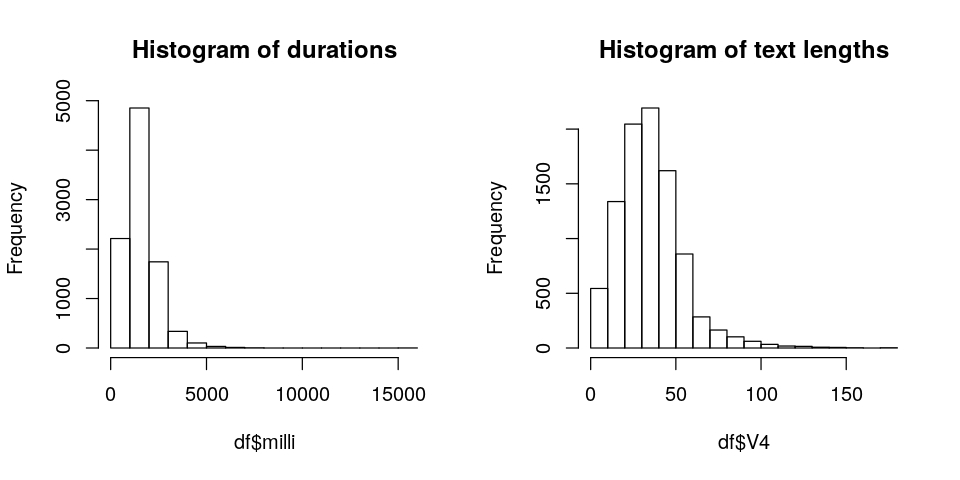

In [24]:
df <- read.table("diagnostics.tsv",sep="\t",header=F,quote="")
df$milli <- df$V2 - df$V1
options(repr.plot.width=8, repr.plot.height=4)
op <- par(mfrow=c(1,2))
hist(df$milli,main="Histogram of durations")
hist(df$V4,main="Histogram of text lengths")
par(op)

## Create wav clips

Simply run the `segsox.sh` script to create the wavs directory

In [25]:
cd /y/south-park-1-to-20
bash segsox.sh

## Manually correct metadata and/or wavs

Any numeric conversion should be checked. Most will be OK, but the dollars/cents rules are heuristics. Example problems:

- $300,000 building -> three hundred thousand dollar~~s~~ building (currency as modifier not noun)

- $2.25 -> two twenty five; actual might have been two dollars and twenty five cents

In general, it would be wise to correct the output data using something like https://github.com/ozdefir/finetuneas

## Next steps

That's it, the dataset is made. The next step is to use a LJSpeech-friendly TTS training algorithm like [mozilla/TTS](https://github.com/mozilla/TTS)